# COCO Dataset Download and Preparation Tutorial

This tutorial will guide you through the process of:
1. Setting up the COCO dataset directory structure
2. Downloading the COCO dataset
3. Converting COCO annotations to YOLO format
4. Creating training and validation text files

## Required Dependencies

First, let's ensure we have all necessary packages installed:

In [ ]:
!pip install requests tqdm opencv-python matplotlib numpy

## 1. Creating Directory Structure

We'll start by creating the necessary directory structure for the COCO dataset. The structure will be:
```
COCO/
├── images/
│   ├── train2017/
│   └── val2017/
├── labels/
│   ├── train2017/
│   └── val2017/
└── annotations/
```

In [ ]:
import os
from pathlib import Path

def create_directory_structure():
    base_dir = "test/COCO"
    dirs = [
        "images/train2017",
        "images/val2017",
        "labels/train2017",
        "labels/val2017",
        "annotations"
    ]
    
    for dir_path in dirs:
        Path(f"{base_dir}/{dir_path}").mkdir(parents=True, exist_ok=True)
    
    return base_dir

base_dir = create_directory_structure()
print(f"Created directory structure in {base_dir}")

## 2. Downloading COCO Dataset

Now we'll download the COCO dataset files. This includes:
- Training images (train2017)
- Validation images (val2017)
- Annotations for both training and validation sets

**Note**: The COCO dataset is quite large (~25GB), so this step might take some time depending on your internet connection.

In [ ]:
import os
import requests
import urllib.request
import zipfile
from tqdm import tqdm

def download_file(url, filename, retries=3, chunk_size=1024):
    """
    Download file with progress bar and retry mechanism
    """
    for attempt in range(retries):
        try:
            print(f"Downloading {filename} (Attempt {attempt + 1}/{retries})...")
            response = requests.get(url, stream=True, timeout=10)
            response.raise_for_status()
            total_size = int(response.headers.get('content-length', 0))
            
            with open(filename, 'wb') as file, tqdm(
                desc=filename, total=total_size, unit='B', unit_scale=True, unit_divisor=1024
            ) as bar:
                for chunk in response.iter_content(chunk_size=chunk_size):
                    file.write(chunk)
                    bar.update(len(chunk))
            
            return True
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {filename}: {e}")
            if attempt < retries - 1:
                print("Retrying...")
            else:
                print("Failed to download after multiple attempts.")
                return False

def extract_zip(filename, destination):
    """
    Extract zip file and handle errors
    """
    print(f"Extracting {filename}...")
    try:
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(destination)
        os.remove(filename)
    except zipfile.BadZipFile:
        print(f"Error: {filename} is not a valid zip file. Skipping extraction.")
        os.remove(filename)

def download_coco_dataset(base_dir="COCO"):
    """
    Download full COCO dataset
    """
    urls = {
        'train_images': 'http://images.cocodataset.org/zips/train2017.zip',
        'val_images': 'http://images.cocodataset.org/zips/val2017.zip',
        'annotations': 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
    }
    
    os.makedirs(base_dir, exist_ok=True)
    
    for name, url in urls.items():
        filename = os.path.join(base_dir, url.split('/')[-1])
        
        if not os.path.exists(filename):
            if not download_file(url, filename):
                continue
        
        extract_zip(filename, base_dir)

download_coco_dataset()

## 3. Converting COCO Annotations to YOLO Format

Next, we'll convert the COCO format annotations to YOLO format. The YOLO format is:
```
[class_id] [x_center] [y_center] [width] [height]
```
where:
- class_id: 0-based integer (COCO has 80 classes)
- x_center, y_center: center coordinates normalized to [0, 1]
- width, height: bbox dimensions normalized to [0, 1]

In [1]:
import json
import os
from tqdm import tqdm

def convert_coco_to_yolo():
    """Convert COCO annotations to YOLO format with validation checks."""
    
    # Define the category mapping
    # In the COCO dataset, category IDs start from 1 and can go beyond 79. However, YOLO expects category IDs to be 0-based
    # and within the range of 0 to 79. Therefore, we need to map the original category IDs (from COCO) to a new 
    # range from 0 to 79 to align with YOLO's expectations.
    # The original COCO categories look like this:
    # [
    #   {"supercategory": "person", "id": 1, "name": "person"},
    #   {"supercategory": "vehicle", "id": 2, "name": "bicycle"},
    #   {"supercategory": "vehicle", "id": 3, "name": "car"},
    #   {"supercategory": "vehicle", "id": 4, "name": "motorcycle"},
    #   {"supercategory": "vehicle", "id": 5, "name": "airplane"},
    #   {"supercategory": "vehicle", "id": 6, "name": "bus"},
    #   {"supercategory": "vehicle", "id": 7, "name": "train"},
    #   {"supercategory": "vehicle", "id": 8, "name": "truck"},
    #   {"supercategory": "vehicle", "id": 9, "name": "boat"},
    #   {"supercategory": "outdoor", "id": 10, "name": "traffic light"},
    #   {"supercategory": "outdoor", "id": 11, "name": "fire hydrant"},
    #   {"supercategory": "outdoor", "id": 13, "name": "stop sign"},
    #   {"supercategory": "outdoor", "id": 14, "name": "parking meter"},
    #   {"supercategory": "outdoor", "id": 15, "name": "bench"},
    #   {"supercategory": "animal", "id": 16, "name": "bird"},
    #   {"supercategory": "animal", "id": 17, "name": "cat"},
    #   {"supercategory": "animal", "id": 18, "name": "dog"},
    #   {"supercategory": "animal", "id": 19, "name": "horse"},
    #   {"supercategory": "animal", "id": 20, "name": "sheep"},
    #   {"supercategory": "animal", "id": 21, "name": "cow"},
    #   {"supercategory": "animal", "id": 22, "name": "elephant"},
    #   {"supercategory": "animal", "id": 23, "name": "bear"},
    #   {"supercategory": "animal", "id": 24, "name": "zebra"},
    #   {"supercategory": "animal", "id": 25, "name": "giraffe"},
    #   {"supercategory": "accessory", "id": 27, "name": "backpack"},
    #   {"supercategory": "accessory", "id": 28, "name": "umbrella"},
    #   {"supercategory": "accessory", "id": 31, "name": "handbag"},
    #   {"supercategory": "accessory", "id": 32, "name": "tie"},
    #   {"supercategory": "accessory", "id": 33, "name": "suitcase"},
    #   {"supercategory": "sports", "id": 34, "name": "frisbee"},
    #   {"supercategory": "sports", "id": 35, "name": "skis"},
    #   {"supercategory": "sports", "id": 36, "name": "snowboard"},
    #   {"supercategory": "sports", "id": 37, "name": "sports ball"},
    #   {"supercategory": "sports", "id": 38, "name": "kite"},
    #   {"supercategory": "sports", "id": 39, "name": "baseball bat"},
    #   {"supercategory": "sports", "id": 40, "name": "baseball glove"},
    #   {"supercategory": "sports", "id": 41, "name": "skateboard"},
    #   {"supercategory": "sports", "id": 42, "name": "surfboard"},
    #   {"supercategory": "sports", "id": 43, "name": "tennis racket"},
    #   {"supercategory": "kitchen", "id": 44, "name": "bottle"},
    #   {"supercategory": "kitchen", "id": 46, "name": "wine glass"},
    #   {"supercategory": "kitchen", "id": 47, "name": "cup"},
    #   {"supercategory": "kitchen", "id": 48, "name": "fork"},
    #   {"supercategory": "kitchen", "id": 49, "name": "knife"},
    #   {"supercategory": "kitchen", "id": 50, "name": "spoon"},
    #   {"supercategory": "kitchen", "id": 51, "name": "bowl"},
    #   {"supercategory": "food", "id": 52, "name": "banana"},
    #   {"supercategory": "food", "id": 53, "name": "apple"},
    #   {"supercategory": "food", "id": 54, "name": "sandwich"},
    #   {"supercategory": "food", "id": 55, "name": "orange"},
    #   {"supercategory": "food", "id": 56, "name": "broccoli"},
    #   {"supercategory": "food", "id": 57, "name": "carrot"},
    #   {"supercategory": "food", "id": 58, "name": "hot dog"},
    #   {"supercategory": "food", "id": 59, "name": "pizza"},
    #   {"supercategory": "food", "id": 60, "name": "donut"},
    #   {"supercategory": "food", "id": 61, "name": "cake"},
    #   {"supercategory": "furniture", "id": 62, "name": "chair"},
    #   {"supercategory": "furniture", "id": 63, "name": "couch"},
    #   {"supercategory": "furniture", "id": 64, "name": "potted plant"},
    #   {"supercategory": "furniture", "id": 65, "name": "bed"},
    #   {"supercategory": "furniture", "id": 67, "name": "dining table"},
    #   {"supercategory": "furniture", "id": 70, "name": "toilet"},
    #   {"supercategory": "electronic", "id": 72, "name": "tv"},
    #   {"supercategory": "electronic", "id": 73, "name": "laptop"},
    #   {"supercategory": "electronic", "id": 74, "name": "mouse"},
    #   {"supercategory": "electronic", "id": 75, "name": "remote"},
    #   {"supercategory": "electronic", "id": 76, "name": "keyboard"},
    #   {"supercategory": "electronic", "id": 77, "name": "cell phone"},
    #   {"supercategory": "appliance", "id": 78, "name": "microwave"},
    #   {"supercategory": "appliance", "id": 79, "name": "oven"},
    #   {"supercategory": "appliance", "id": 80, "name": "toaster"},
    #   {"supercategory": "appliance", "id": 81, "name": "sink"},
    #   {"supercategory": "appliance", "id": 82, "name": "refrigerator"},
    #   {"supercategory": "indoor", "id": 84, "name": "book"},
    #   {"supercategory": "indoor", "id": 85, "name": "clock"},
    #   {"supercategory": "indoor", "id": 86, "name": "vase"},
    #   {"supercategory": "indoor", "id": 87, "name": "scissors"},
    #   {"supercategory": "indoor", "id": 88, "name": "teddy bear"},
    #   {"supercategory": "indoor", "id": 89, "name": "hair drier"},
    #   {"supercategory": "indoor", "id": 90, "name": "toothbrush"}
    # ]
    # As you can see, some category IDs (such as 12, 16, 26, etc.) are missing in this sequence. 
    # We need to fix this by providing a continuous mapping of category_ids from 0 to 79.
    
    category_mapping = {
        1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 
        15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 24: 22, 25: 23, 
        27: 24, 28: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 
        40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 
        52: 46, 53: 47, 54: 48, 55: 49, 56: 50, 57: 51, 58: 52, 59: 53, 60: 54, 61: 55, 62: 56, 
        63: 57, 64: 58, 65: 59, 67: 60, 70: 61, 72: 62, 73: 63, 74: 64, 75: 65, 76: 66, 77: 67, 
        78: 68, 79: 69, 80: 70, 81: 71, 82: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 
        79: 79
    }

    def convert_bbox(size, box):
        # Convert COCO bbox [x, y, w, h] to YOLO bbox [x_center, y_center, w, h]
        dw = 1. / size[0]
        dh = 1. / size[1]
        
        # COCO bbox format: [x_min, y_min, width, height]
        x_min, y_min, w, h = box
        
        # Convert to YOLO format (center_x, center_y, width, height)
        x_center = (x_min + w / 2) * dw  # Normalize x_center to [0, 1]
        y_center = (y_min + h / 2) * dh  # Normalize y_center to [0, 1]
        w = w * dw  # Normalize width to [0, 1]
        h = h * dh  # Normalize height to [0, 1]
        
        # Ensure coordinates are valid (in case of any rounding issues)
        x_center = min(max(x_center, 0), 1)
        y_center = min(max(y_center, 0), 1)
        w = min(max(w, 0), 1)
        h = min(max(h, 0), 1)
        
        return (x_center, y_center, w, h)

    # Process both training and validation sets
    for dataset in ['train2017', 'val2017']:
        print(f"\nProcessing {dataset}...")
        
        # Load JSON file containing the COCO annotations
        json_file = f'Dataset/COCO/annotations/instances_{dataset}.json'
        with open(json_file) as f:
            data = json.load(f)

        # Create a dictionary that maps image ids to their data (including annotations)
        image_dict = {}
        for img in data['images']:
            image_dict[img['id']] = {
                'file_name': img['file_name'],
                'width': img['width'],
                'height': img['height'],
                'annotations': []
            }

        # Group annotations by image
        for ann in data['annotations']:
            if ann['bbox'][2] > 0 and ann['bbox'][3] > 0:  # Filter out invalid bounding boxes
                image_dict[ann['image_id']]['annotations'].append(ann)

        # Convert COCO annotations to YOLO format and save them
        for img_id, img_data in tqdm(image_dict.items()):
            if not img_data['annotations']:
                continue

            # Create directory for YOLO labels (if it doesn't exist already)
            label_dir = f"Dataset/COCO/labels/{dataset}"
            os.makedirs(label_dir, exist_ok=True)
            label_file = f"{label_dir}/{os.path.splitext(img_data['file_name'])[0]}.txt"
            
            with open(label_file, 'w') as f:
                for ann in img_data['annotations']:
                    # Look up the category_id using the category_mapping dictionary
                    # COCO category_id starts from 1, but we map it to YOLO format (0-based indexing)
                    category_id = category_mapping.get(ann['category_id'])
                    
                    # If the category_id exists in the mapping, process the annotation
                    if category_id is not None:
                        # Convert bounding box to YOLO format (normalized)
                        bbox = convert_bbox((img_data['width'], img_data['height']), ann['bbox'])
                        
                        # Validate bounding box values to ensure they are within the valid range [0, 1]
                        if all(0 <= x <= 1 for x in bbox):
                            # Write the annotation in YOLO format: category_id x_center y_center width height
                            f.write(f"{category_id} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

# Convert annotations
convert_coco_to_yolo()



Processing train2017...


100%|██████████| 118287/118287 [00:18<00:00, 6528.00it/s]



Processing val2017...


100%|██████████| 5000/5000 [00:00<00:00, 7044.64it/s]


## 4. Creating Training and Validation Text Files

Finally, we'll create text files listing all images in the training and validation sets. These files will contain the paths to all images and will be used during training.

In [ ]:
def create_image_lists():
    dataset_path = Path('./Dataset/COCO')
    
    # Create train2017.txt
    train_images = list((dataset_path / 'images' / 'train2017').glob('*.jpg'))
    with open(dataset_path / 'train2017.txt', 'w') as f:
        for img_path in train_images:
            f.write(f'./Dataset/COCO/images/train2017/{img_path.name}\n')
    
    # Create val2017.txt
    val_images = list((dataset_path / 'images' / 'val2017').glob('*.jpg'))
    with open(dataset_path / 'val2017.txt', 'w') as f:
        for img_path in val_images:
            f.write(f'./Dataset/COCO/images/val2017/{img_path.name}\n')
    
    print(f"Created train2017.txt with {len(train_images)} images")
    print(f"Created val2017.txt with {len(val_images)} images")

create_image_lists()

## Verification

Let's verify that our dataset is properly structured and all necessary files are in place:

In [ ]:
from pathlib import Path

def verify_dataset():
    base_dir = Path("Dataset/COCO")
    
    # Check directory structure
    required_dirs = [
        "images/train2017",
        "images/val2017",
        "labels/train2017",
        "labels/val2017",
        "annotations"
    ]
    
    for dir_path in required_dirs:
        full_path = base_dir / dir_path
        if not full_path.exists():
            print(f"❌ Missing directory: {dir_path}")
        else:
            print(f"✅ Found directory: {dir_path}")
    
    # Check text files
    for txt_file in ["train2017.txt", "val2017.txt"]:
        if (base_dir / txt_file).exists():
            print(f"✅ Found file: {txt_file}")
        else:
            print(f"❌ Missing file: {txt_file}")
    
    # Check all label files and verify category_id range
    print("\nChecking label files format and category_id range...")
    for dataset in ["train2017", "val2017"]:
        label_dir = base_dir / "labels" / dataset
        if label_dir.exists():
            label_files = list(label_dir.glob("*.txt"))
            if label_files:
                for label_file in label_files:
                    with open(label_file) as f:
                        lines = f.readlines()
                        for line in lines:
                            # Split the line to get the category_id
                            category_id = int(line.split()[0])
                            # Check if category_id is within the valid range of 0-79
                            if category_id < 0 or category_id > 79:
                                print(f"❌ Invalid category_id {category_id} found in file {label_file.name}")
                                break
                print(f"✅ All category_ids in {label_dir} are within the valid range (0-79).")
            else:
                print(f"❌ No label files found in {label_dir}")
        else:
            print(f"❌ Missing label directory: {label_dir}")
    
verify_dataset()


✅ Found directory: images/train2017
✅ Found directory: images/val2017
✅ Found directory: labels/train2017
✅ Found directory: labels/val2017
✅ Found directory: annotations
✅ Found file: train2017.txt
✅ Found file: val2017.txt

Checking label files format and category_id range...
✅ All category_ids in Dataset/COCO/labels/train2017 are within the valid range (0-79).
✅ All category_ids in Dataset/COCO/labels/val2017 are within the valid range (0-79).


In [ ]:
def verify_dataset():
    base_dir = Path("Dataset/COCO")
    
    # Check directory structure
    required_dirs = [
        "images/train2017",
        "images/val2017",
        "labels/train2017",
        "labels/val2017",
        "annotations"
    ]
    
    for dir_path in required_dirs:
        full_path = base_dir / dir_path
        if not full_path.exists():
            print(f"❌ Missing directory: {dir_path}")
        else:
            print(f"✅ Found directory: {dir_path}")
    
    # Check text files
    for txt_file in ["train2017.txt", "val2017.txt"]:
        if (base_dir / txt_file).exists():
            print(f"✅ Found file: {txt_file}")
        else:
            print(f"❌ Missing file: {txt_file}")
    
    # Sample some label files
    print("\nChecking label files format...")
    for dataset in ["train2017", "val2017"]:
        label_dir = base_dir / "labels" / dataset
        if label_dir.exists():
            label_files = list(label_dir.glob("*.txt"))
            if label_files:
                sample_file = label_files[0]
                print(f"\nSample {dataset} label file ({sample_file.name}):")
                with open(sample_file) as f:
                    print(f.read().strip())

verify_dataset()

## Visualization of Train and Test Data with Bounding Boxes

Let's visualize some images from the training and validation sets along with their bounding boxes in a 3x3 grid:

Training Images with Bounding Boxes:


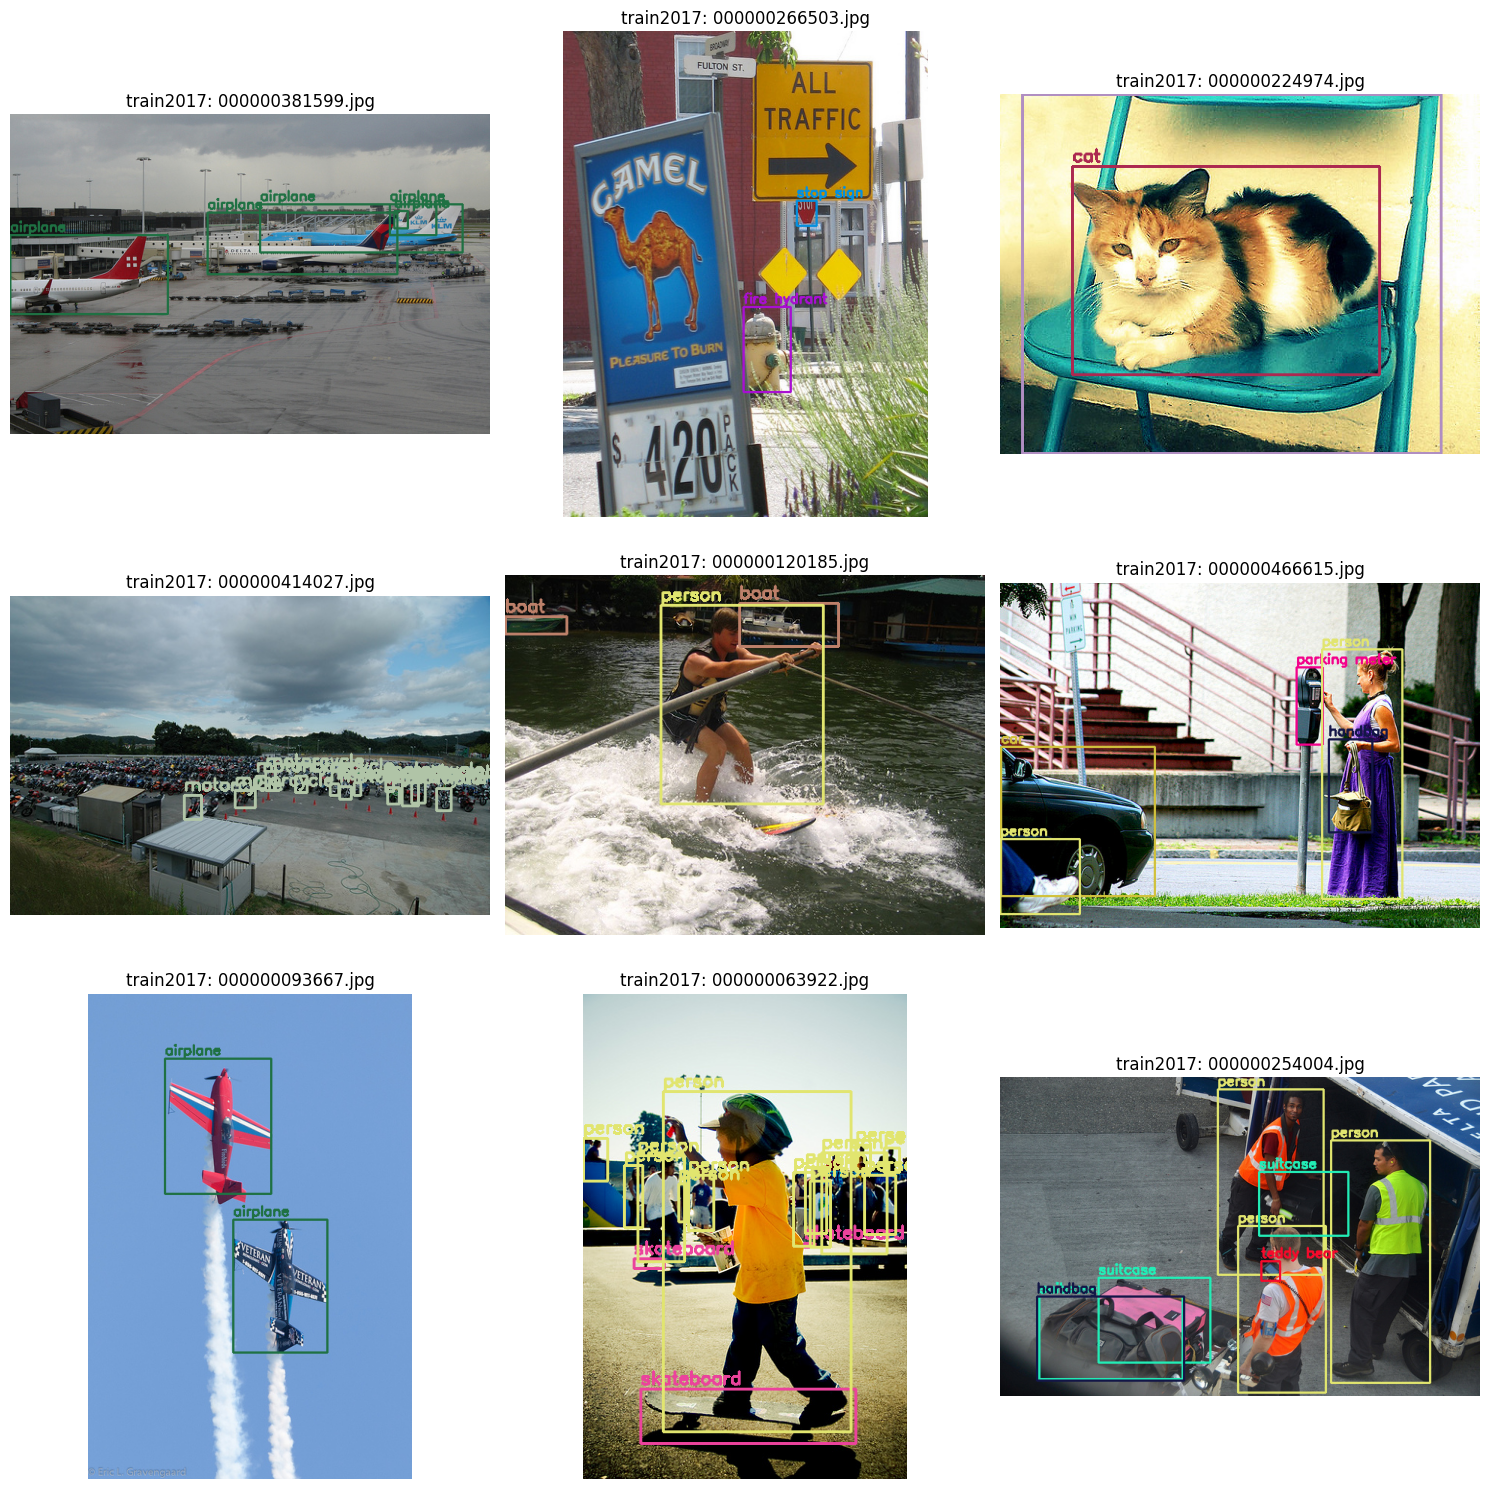


Test Images with Bounding Boxes:


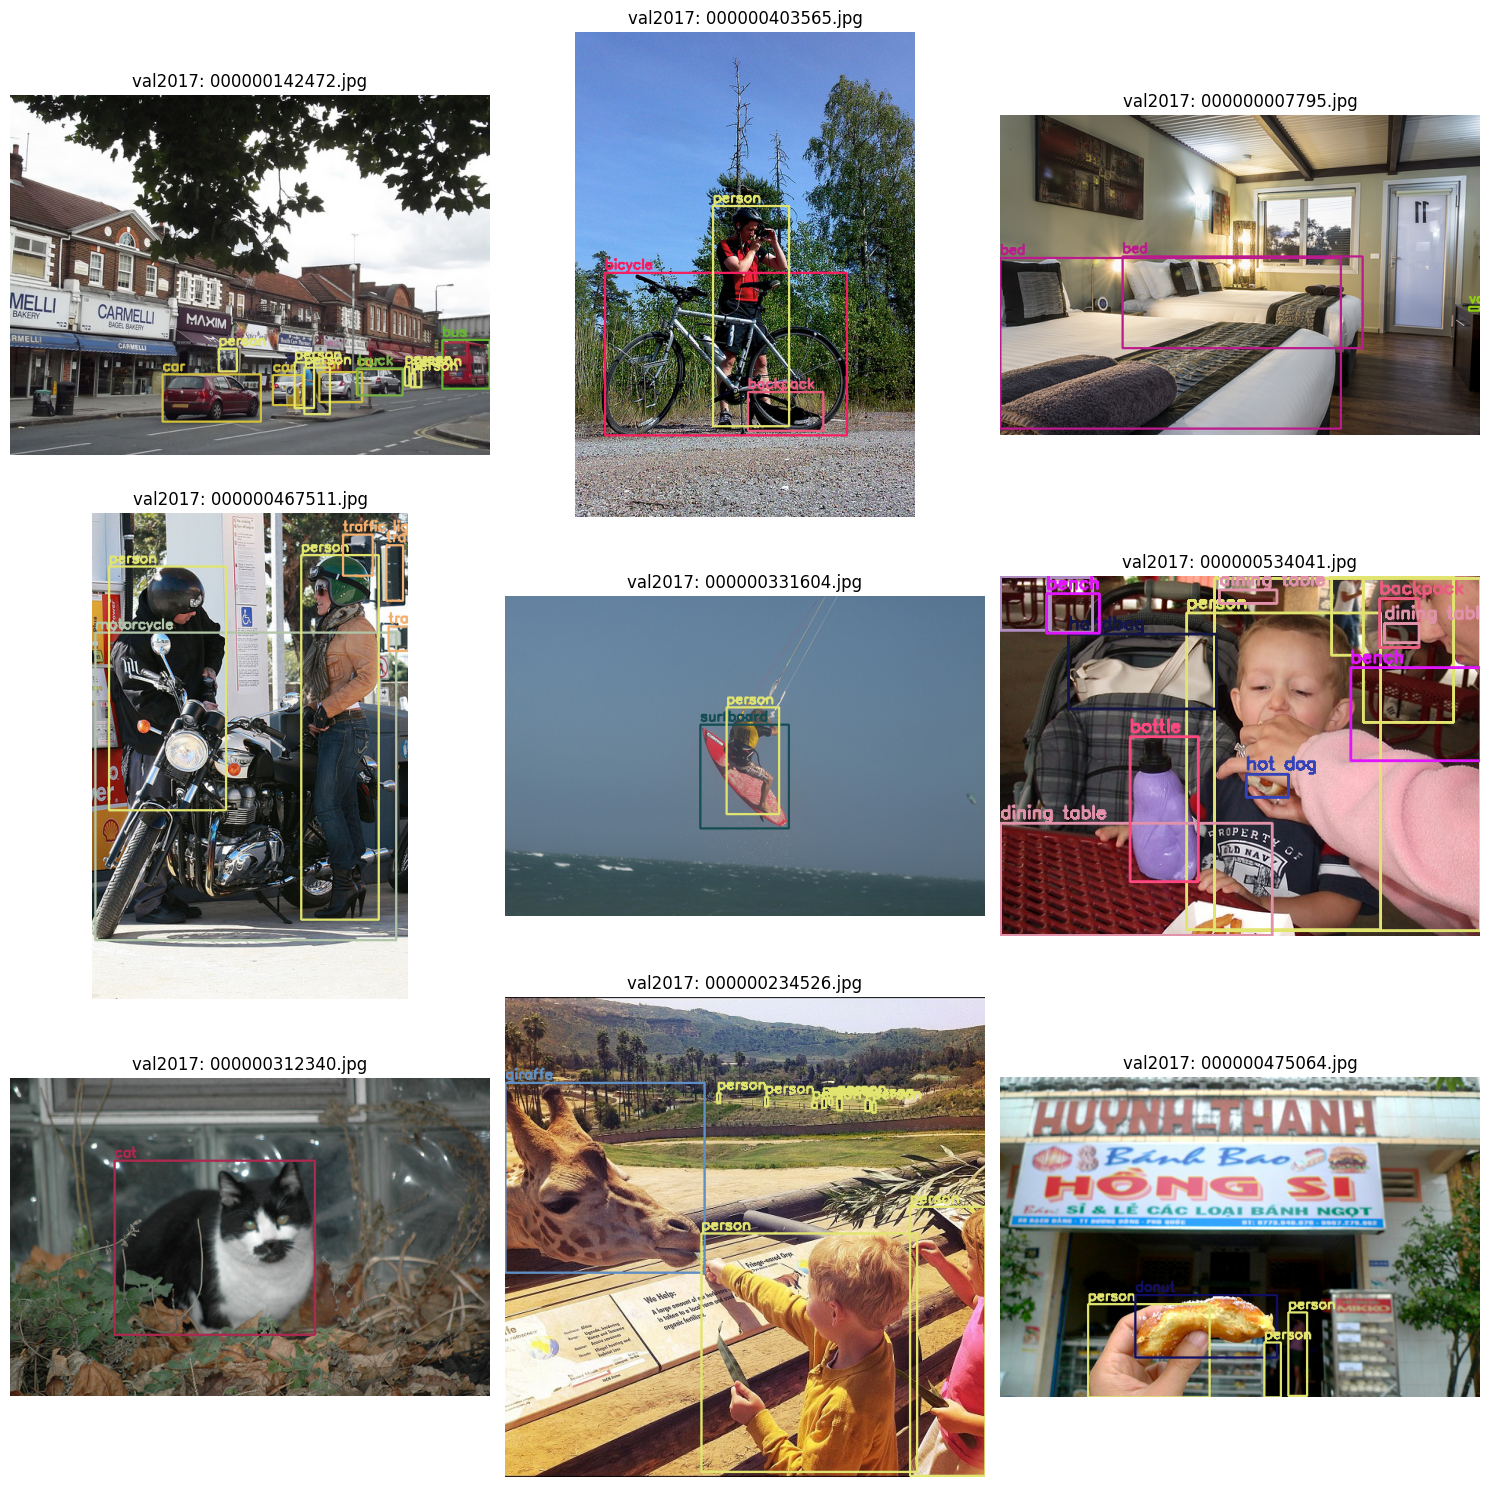

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import yaml

# Load class names from args.yaml
def load_class_names(yaml_path="utils/args.yaml"):
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    return config['names']

# Function to generate random color for each class
def generate_class_colors(class_names):
    colors = {}
    for idx, name in enumerate(class_names):
        # Generate a random color for each class (RGB)
        colors[idx] = tuple(np.random.randint(0, 256, 3).tolist())
    return colors

def plot_images_with_bboxes(dataset, num_images=9, class_names=None, class_colors=None):
    base_dir = "Dataset/COCO"
    image_dir = os.path.join(base_dir, "images", dataset)
    label_dir = os.path.join(base_dir, "labels", dataset)
    
    # Get all image files and randomly sample num_images
    all_images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    selected_images = random.sample(all_images, min(num_images, len(all_images)))
    
    # Create a 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')
        
        # Read and convert image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Draw bounding boxes if label file exists
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    values = line.strip().split()
                    class_id = int(values[0])  # First value is class ID
                    x_center, y_center, width, height = map(float, values[1:])
                    
                    # Convert normalized coordinates to pixel coordinates
                    x_center *= img.shape[1]
                    y_center *= img.shape[0]
                    width *= img.shape[1]
                    height *= img.shape[0]
                    
                    # Calculate box coordinates
                    x_min = int(x_center - width / 2)
                    y_min = int(y_center - height / 2)
                    x_max = int(x_center + width / 2)
                    y_max = int(y_center + height / 2)
                    
                    # Draw rectangle with random color based on class
                    color = class_colors.get(class_id, (0, 255, 0))  # Default to green if class id is not in class_colors
                    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
                    
                    # Put class name instead of class number
                    class_name = class_names.get(class_id, f"Class {class_id}")
                    cv2.putText(img, class_name, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f"{dataset}: {img_name}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load class names and colors
class_names = load_class_names()
class_colors = generate_class_colors(class_names)

# Plot training images
print("Training Images with Bounding Boxes:")
plot_images_with_bboxes('train2017', class_names=class_names, class_colors=class_colors)

# Plot test images
print("\nTest Images with Bounding Boxes:")
plot_images_with_bboxes('val2017', class_names=class_names, class_colors=class_colors)


## Conclusion

You have now successfully:
1. Created the necessary directory structure for the COCO dataset
2. Downloaded the COCO dataset images and annotations
3. Converted COCO format annotations to YOLO format
4. Created text files listing all training and validation images
5. Verified the dataset structure and format
6. Visualized training and validation images with bounding boxes

The dataset is now ready to be used for training YOLO models. The directory structure should look like this:
```
Dataset/COCO/
├── images/
│   ├── train2017/  (contains training images)
│   └── val2017/    (contains validation images)
├── labels/
│   ├── train2017/  (contains YOLO format labels for training images)
│   └── val2017/    (contains YOLO format labels for validation images)
├── annotations/    (contains original COCO format annotations)
├── train2017.txt  (list of training image paths)
└── val2017.txt    (list of validation image paths)
```